# Comparison of parser results, Maltparser, optimized settings

This notebook will perform the same experiments as [the previous one](/notebooks/4.%20Analysis%20of%20parser%20results%20%28Mate%20tools%29.ipynb) for Mate tools, only instead using Maltparser run with default settings. We are also testing the entire UD 1.1 collection, instead of just looking at 1.0 as for Mate.

## Preprocessing

The conllu files had to be preprocessed to support the conllx format. This was done using the `tools/conllu2conllx.py` script. Thereafter the models were trained and tested with `tools/train_maltparser_default.py` and `tools/test_maltparser_default.py`.

#### Functional and content dependents
As specified in [A manual classification of dependency relations](/notebooks/3.%20A%20manual%20classification%20of%20dependency%20relations.ipynb)

- Functional dependents
- Content dependendents

#### Dependent classes as specified in the [UD documentation](http://universaldependencies.github.io/docs/u/dep/index.html)

- Classes expected to perform better than overall LAS for __synthetic__ languages:
  - __Core dependents of clausal predicates__: nsubj, csubj, nsubjpass, csubjpass, dobj, ccomp, xcomp, iobj
  - __Non-core dependents of clausal predicates__: nmod, advcl, advmod, neg
  - __Noun dependents, excluding _det_ and _neg___: nummod, acl, amod, appos, nmod
  - __Coordination, excluding _cc_ and _punct___: conj
  - 
- Classes expected to perform better than overall LAS for __isolated__ languages:
  - __Special clausal dependents__: vocative, aux, mark, discourse, auxpass, punct, expl, cop
  - __Case-marking, prepositions, possessive__: case


## Things to keep in mind when looking at the results

- Irish and Hungarian has fairly little data, and can't probably be trusted. 
- Czech has A LOT of data.

In [5]:
# My classes
content_dependents = ("acl", "advcl", "advmod", "amod", "appos", "ccomp", "compound", "conj", "csubj", "csubjpass", "dislocated", "dobj", "iobj", "list", "name", "nmod", "nsubj", "nsubjpass", "nummod", "parataxis", "remnant", "root", "vocative", "xcomp")
function_dependents = ('aux', 'auxpass', 'case', 'cc', 'cop', 'det', 'expl', 'mark', 'neg', 'mwe')
nonsemantic_dependents = ("punct", "discourse", "reparandum", "dep", "goeswith", "foreign")

# UD classes
core_dependents = ['nsubj', 'csubj', 'nsubjpass', 'csubjpass', 'dobj', 'ccomp', 'xcomp', 'iobj']
noncore_dependents = ['nmod', 'advcl', 'advmod', 'neg']
noun_dependents = ['nummod', 'acl', 'amod', 'appos', 'nmod']
coordination_dependents = ['conj']
special_clausal_dependents = ['vocative', 'aux', 'mark', 'discourse', 'auxpass', 'expl', 'cop']
other_functional_dependents = ['det', 'cc', 'case', 'mwe']

all_labels = content_dependents + function_dependents + nonsemantic_dependents

In [9]:
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
from os.path import join
sys.path.append("../tools/")
import udeval

import pandas as pd
import seaborn as sns
from collections import defaultdict

system_output_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/maltopt_output/"
gold_output_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1/"

system_output = {"UD_Basque": "UD_Basque.conllx",
                "UD_Croatian": "UD_Croatian.conllx",
                "UD_Danish": "UD_Danish.conllx",
#                "UD_Finnish": "UD_Finnish.conllx",
                "UD_French": "UD_French.conllx",
                "UD_Greek": "UD_Greek.conllx",
                "UD_Hungarian": "UD_Hungarian.conllx",
                "UD_Irish": "UD_Irish.conllx",
                "UD_Persian": "UD_Persian.conllx",
                "UD_Swedish": "UD_Swedish.conllx",
                "UD_Bulgarian": "UD_Bulgarian.conllx",
#                "UD_Czech": "UD_Czech.conllx",
                "UD_English": "UD_English.conllx",
                "UD_Finnish-FTB": "UD_Finnish-FTB.conllx",
                "UD_German": "UD_German.conllx",
                "UD_Hebrew": "UD_Hebrew.conllx",
                "UD_Indonesian": "UD_Indonesian.conllx",
                "UD_Italian": "UD_Italian.conllx",
                "UD_Spanish": "UD_Spanish.conllx"}

gold_file = {'UD_Basque': 'eu-ud-test.conllu',
            'UD_Croatian': 'hr-ud-test.conllu',
            'UD_Danish': 'da-ud-test.conllu',
            'UD_Finnish': 'fi-ud-test.conllu',
            'UD_French': 'fr-ud-test.conllu',
            'UD_Greek': 'el-ud-test.conllu',
            'UD_Hungarian': 'hu-ud-test.conllu',
            'UD_Irish': 'ga-ud-test.conllu',
            'UD_Persian': 'fa-ud-test.conllu',
            'UD_Swedish': 'sv-ud-test.conllu',
            'UD_Bulgarian': 'bg-ud-test.conllu',
            'UD_Czech': 'cs-ud-test.conllu',
            'UD_English': 'en-ud-test.conllu',
            'UD_Finnish-FTB': 'fi_ftb-ud-test.conllu',
            'UD_German': 'de-ud-test.conllu',
            'UD_Hebrew': 'he-ud-test.conllu',
            'UD_Indonesian': 'id-ud-test.conllu',
            'UD_Italian': 'it-ud-test.conllu',
            'UD_Spanish': 'es-ud-test.conllu'}

In [10]:
def labeled_attachment_scores():
    las = {}
    for lang in system_output.keys():
        s_out =  join(system_output_path, system_output[lang])
        g_out = join(gold_output_path, lang, gold_file[lang])
        score = udeval.attachment_score(s_out, g_out, labeled=True)
        las[lang] = score
    return pd.Series(las)
        
def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang in system_output.keys():
        s_out =  join(system_output_path, system_output[lang])
        g_out = join(gold_output_path, lang, gold_file[lang])
        precision, recall = udeval.labels_precision_recall(s_out, 
                                                           g_out, 
                                                           labels=labels)
        index.append(lang)
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

In [11]:
labeled_attachment_scores()

UD_Basque         0.664478
UD_Bulgarian      0.861073
UD_Croatian       0.714424
UD_Danish         0.771360
UD_English        0.801124
UD_Finnish-FTB    0.789778
UD_French         0.743325
UD_German         0.738395
UD_Greek          0.737650
UD_Hebrew         0.562887
UD_Hungarian      0.472294
UD_Indonesian     0.756961
UD_Irish          0.624967
UD_Italian        0.822964
UD_Persian        0.646798
UD_Spanish        0.774068
UD_Swedish        0.756392
dtype: float64

In [12]:
all_labels_results = precision_recall_filter_labels(all_labels)
all_labels_results

,precision,recall
UD_Hungarian,0.472294,0.472294
UD_Hebrew,0.563770,0.563770
UD_Irish,0.624967,0.624967
UD_Persian,0.646798,0.646798
UD_Basque,0.664478,0.664478
UD_Croatian,0.714424,0.714424
UD_Greek,0.737650,0.737650
UD_German,0.738395,0.738395
UD_French,0.743325,0.743325
UD_Swedish,0.756392,0.756392


In [13]:
label_result = dict()
for label in all_labels:
    label_result[label] = precision_recall_filter_labels([label])

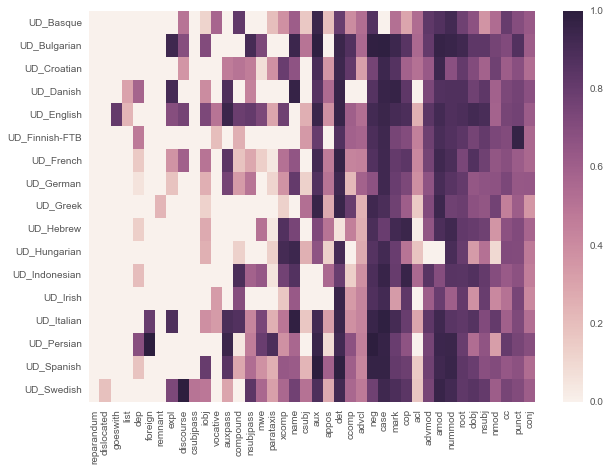

In [14]:
# Sort precision heatmap with languages according to standard ttr, 
# dependency labels according to cross-language entropy
dep_entropy = pd.Series.from_csv('../data/crosslingual_dependency_entropy.csv').index
dep_entropy = [label for label in dep_entropy if label != "subj"]  # remove hebrew bug
#sttr = ["fi", "cs", "de", "hu", "fr", "es", "ga", "sv", "it", "en"]
labels_precision = pd.DataFrame({y:x['precision'] for y,x in label_result.items()})
absolute_precision_scores = labels_precision[dep_entropy].fillna(0)
sns.heatmap(absolute_precision_scores)

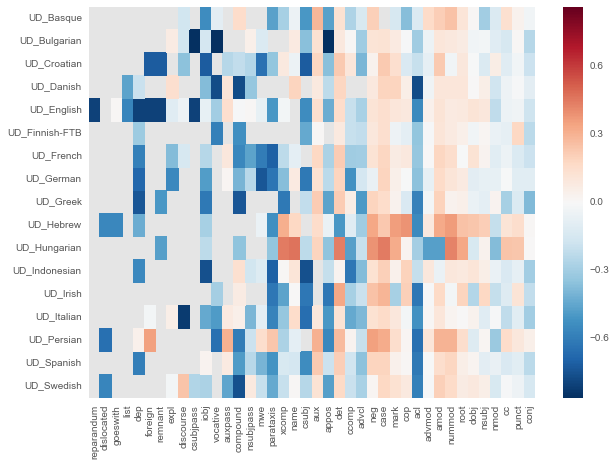

In [15]:
relative_precision_scores = labels_precision.subtract(all_labels_results['precision'], axis=0)[dep_entropy]
sns.heatmap(relative_precision_scores);

__TODO__: Analysis

# Performance for dependency classes

We calculate the precision and recall only using the labels classified as content relations. We then subtract the LAS to present how large of an increase (or reduction) in results the label class gets.

### Content and function relations

#### Absolute performance

In [35]:
content_dependents_result = precision_recall_filter_labels(content_dependents)
function_dependents_result = precision_recall_filter_labels(function_dependents)
results_dict = {"Content dependents": content_dependents_result, 
                "Function dependents": function_dependents_result}

content_function_results = pd.concat(results_dict.values(), keys=results_dict.keys(), axis=1)
content_function_results.sort_values(('Content dependents', 'precision'))

Content dependents           Function dependents          
                        precision    recall           precision    recall
UD_Hungarian             0.289655  0.289655            0.853913  0.853913
UD_Irish                 0.509208  0.509208            0.787589  0.787589
UD_Persian               0.530614  0.530614            0.881665  0.881665
UD_Hebrew                0.562171  0.562171            0.542353  0.542353
UD_Basque                0.610317  0.610317            0.806492  0.806492
UD_German                0.676101  0.676101            0.879722  0.879722
UD_Greek                 0.676480  0.676480            0.868186  0.868186
UD_Spanish               0.685830  0.685830            0.911869  0.911869
UD_French                0.687464  0.687464            0.857091  0.857091
UD_Croatian              0.688460  0.688460            0.817427  0.817427
UD_Swedish               0.701590  0.701590            0.866566  0.866566
UD_Danish                0.744139  0.744139            0.908288  0.908288
UD_Indonesian            0.751247  0.751247            0.846969  0.846969
UD_Italian               0.752855  0.752855            0.929947  0.929947
UD_English               0.753426  0.753426            0.915950  0.915950
UD_Finnish-FTB           0.757291  0.757291            0.796610  0.796610
UD_Bulgarian             0.819700  0.819700            0.938895  0.938895

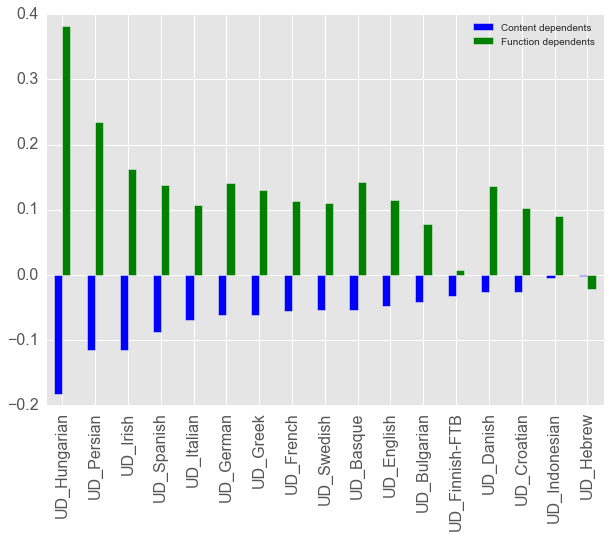

In [26]:
content_function_precisions = content_function_results.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
content_function_precisions.sort_values('Content dependents').plot(kind='bar', fontsize=16)

In [18]:
core_dependent_result = precision_recall_filter_labels(core_dependents)
noncore_dependents_result = precision_recall_filter_labels(noncore_dependents)
noun_dependents_result = precision_recall_filter_labels(noun_dependents)
coordination_dependents_result = precision_recall_filter_labels(coordination_dependents)
special_clausal_dependents_result = precision_recall_filter_labels(special_clausal_dependents)
other_functional_dependents_result = precision_recall_filter_labels(other_functional_dependents)

ud_result_dict = {'Core': core_dependent_result,
                  'Noncore': noncore_dependents_result,
                  'Noun': noun_dependents_result,
                  'Coordination': coordination_dependents_result,
                  'Special clausal': special_clausal_dependents_result,
                  'Functionals': other_functional_dependents_result}

ud_class_result = pd.concat(ud_result_dict.values(), keys=ud_result_dict.keys(), axis=1)
ud_class_result

Noun                Core             Noncore            \
               precision    recall precision    recall precision    recall   
UD_Basque       0.616680  0.616680  0.469006  0.469006  0.611712  0.611712   
UD_Bulgarian    0.822702  0.822702  0.817365  0.817365  0.764238  0.764238   
UD_Croatian     0.773849  0.773849  0.645914  0.645914  0.741401  0.741401   
UD_Danish       0.669223  0.669223  0.790123  0.790123  0.657920  0.657920   
UD_English      0.653312  0.653312  0.867245  0.867245  0.667895  0.667895   
UD_Finnish-FTB  0.765798  0.765798  0.763925  0.763925  0.744483  0.744483   
UD_French       0.685841  0.685841  0.755125  0.755125  0.675220  0.675220   
UD_German       0.723108  0.723108  0.591051  0.591051  0.666013  0.666013   
UD_Greek        0.749502  0.749502  0.633626  0.633626  0.731688  0.731688   
UD_Hebrew       0.461248  0.461248  0.708891  0.708891  0.404934  0.404934   
UD_Hungarian    0.129073  0.129073  0.418879  0.418879  0.114374  0.114374   
UD_Indonesian   0.693015  0.693015  0.776676  0.776676  0.722319  0.722319   
UD_Irish        0.431579  0.431579  0.468278  0.468278  0.463450  0.463450   
UD_Italian      0.787127  0.787127  0.703930  0.703930  0.797406  0.797406   
UD_Persian      0.474828  0.474828  0.631579  0.631579  0.372889  0.372889   
UD_Spanish      0.696562  0.696562  0.717949  0.717949  0.711237  0.711237   
UD_Swedish      0.660074  0.660074  0.785151  0.785151  0.651344  0.651344   

               Special clausal           Functionals           Coordination  \
                     precision    recall   precision    recall    precision   
UD_Basque             0.799861  0.799861    0.800983  0.800983     0.632653   
UD_Bulgarian          0.928571  0.928571    0.935818  0.935818     0.617021   
UD_Croatian           0.758454  0.758454    0.832753  0.832753     0.532338   
UD_Danish             0.881988  0.881988    0.922830  0.922830     0.680365   
UD_English            0.902449  0.902449    0.916902  0.916902     0.620968   
UD_Finnish-FTB        0.750571  0.750571    0.817429  0.817429     0.558824   
UD_French             0.802247  0.802247    0.867188  0.867188     0.560345   
UD_German             0.807097  0.807097    0.906099  0.906099     0.643264   
UD_Greek              0.837912  0.837912    0.873528  0.873528     0.355140   
UD_Hebrew             0.875706  0.875706    0.487264  0.487264     0.570815   
UD_Hungarian          0.727273  0.727273    0.867617  0.867617     0.478261   
UD_Indonesian         0.861111  0.861111    0.844250  0.844250     0.458661   
UD_Irish              0.437008  0.437008    0.874745  0.874745     0.414634   
UD_Italian            0.888734  0.888734    0.935747  0.935747     0.524725   
UD_Persian            0.773333  0.773333    0.916090  0.916090     0.696868   
UD_Spanish            0.857868  0.857868    0.921875  0.921875     0.539394   
UD_Swedish            0.866703  0.866703    0.870306  0.870306     0.612172   

                          
                  recall  
UD_Basque       0.632653  
UD_Bulgarian    0.617021  
UD_Croatian     0.532338  
UD_Danish       0.680365  
UD_English      0.620968  
UD_Finnish-FTB  0.558824  
UD_French       0.560345  
UD_German       0.643264  
UD_Greek        0.355140  
UD_Hebrew       0.570815  
UD_Hungarian    0.478261  
UD_Indonesian   0.458661  
UD_Irish        0.414634  
UD_Italian      0.524725  
UD_Persian      0.696868  
UD_Spanish      0.539394  
UD_Swedish      0.612172

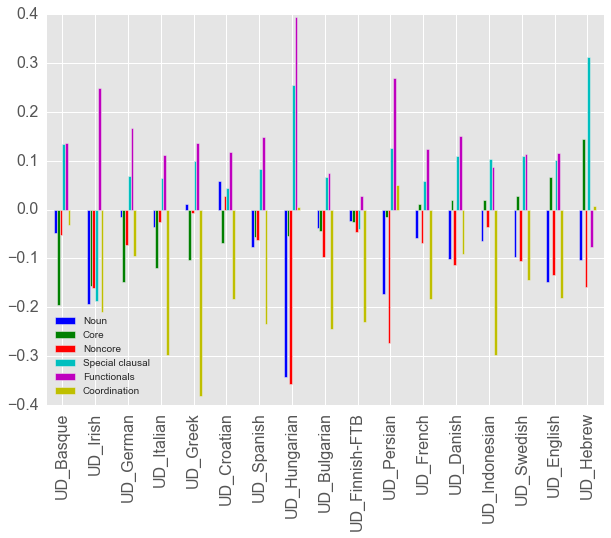

In [19]:
relative_ud_class_result = ud_class_result.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
relative_ud_class_result.sort_values('Core').plot(kind='bar', fontsize=16)

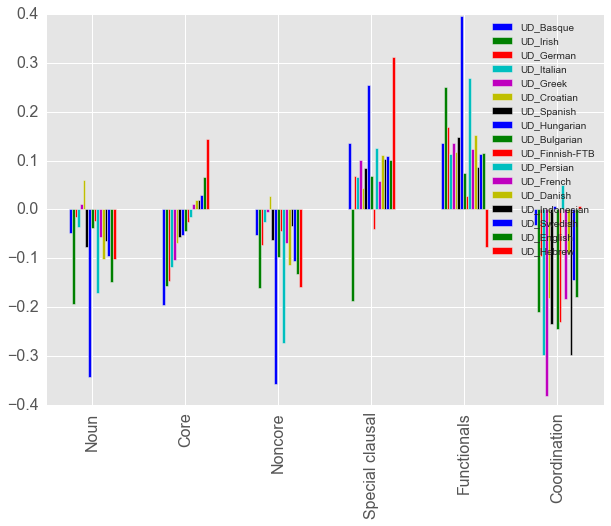

In [20]:
relative_ud_class_result.sort_values("Core").transpose().plot(kind='bar', fontsize=16)

In [36]:
add_order = [('core', core_dependents), 
             ('noun', noun_dependents), 
             ('non_core', noncore_dependents), 
             ('coord', coordination_dependents), 
             ('specl', special_clausal_dependents),
#             ('functionals', other_functional_dependents)
            ]


labels = []
cumul_results = []
cumul_name = ""
for class_name, label_class in add_order:
    labels += label_class
    labels_result = precision_recall_filter_labels(labels)
    cumul_name += "+" + class_name
    cumul_results.append((cumul_name, labels_result))

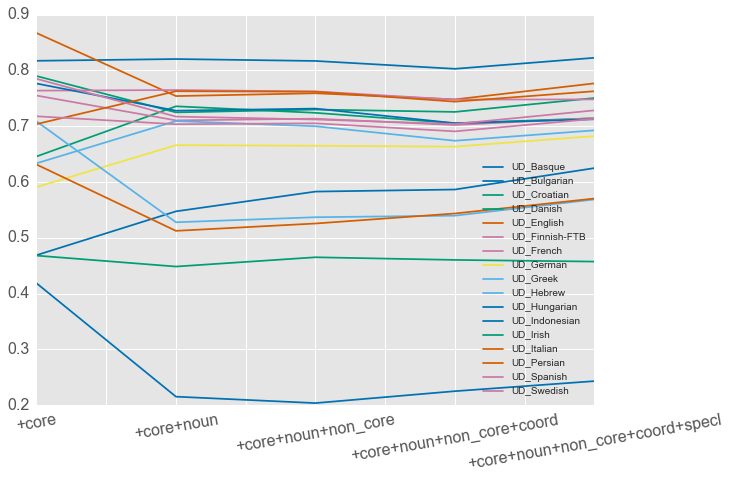

In [37]:
cmap1 = mpl.colors.ListedColormap(sns.color_palette("colorblind", 10))
pd.DataFrame([x[1]['precision'] for x in cumul_results], index=[x[0] for x in cumul_results]).plot(rot=10, fontsize=16, cmap=cmap1)

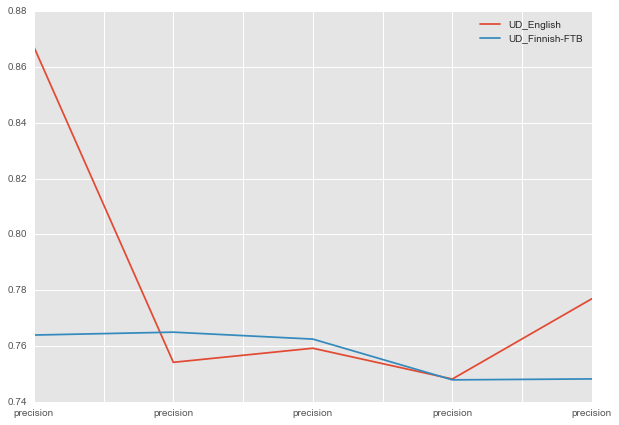

In [54]:
pd.DataFrame([(x[1].ix[['UD_English', 'UD_Finnish-FTB']]['precision']) for x in cumul_results]).plot()

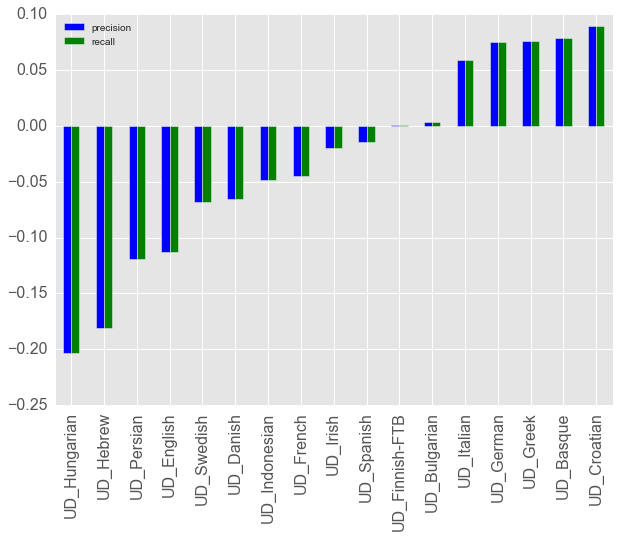

In [55]:
(cumul_results[1][1] - cumul_results[0][1]).sort_values("precision").plot(kind='bar', fontsize=16)